## Сезонная декомпозиция

Инсталируем версии statsmodels==0.11.1 и fbprophet


In [1]:
!pip install statsmodels==0.11.1

     |████████████████████████████████| 8.7MB 3.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
!pip install fbprophet

In [0]:
Импорт модулей для работы

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


from statsmodels.tsa.seasonal import STL

from statsmodels.datasets import elec_equip as ds


1. Читаем с локального диска данные

In [4]:
from google.colab import files
uploaded = files.upload()

Saving my_PJME_MW.csv to my_PJME_MW.csv


Читаем данные в память - причесываем немного и берем для работы 1-й столбец (остальные можно было бы убрать)

In [42]:

Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data = data.sort_index()
data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace=True)
data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Создаем модель для анализа сезонности по (Seasonal
Transformation using LOESS — «STL»  https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html , LOESS- метод локальных полиномиальных регрессий  (Методы социально-экономического прогнозирования в 2т. т.2 - Светуньков) и https://www.machinelearningmastery.ru/decompose-time-series-data-trend-seasonality/)
- вычисление тренда
- подбор сглаживания
- оценка остатков



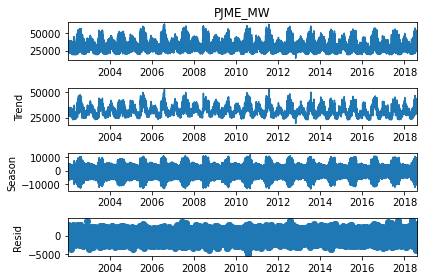

In [43]:
stl = STL(data['PJME_MW'], period=24)
res = stl.fit()
fig = res.plot()

Получили тренд и сезон, посмотрим

In [0]:
Trend = res.trend
Season = res.seasonal


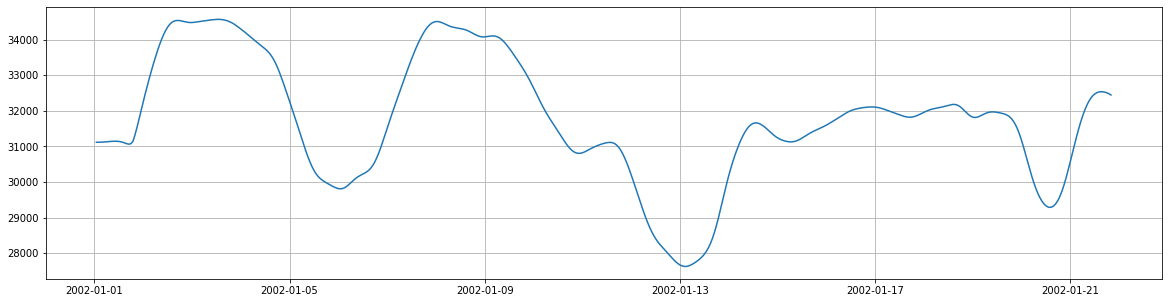

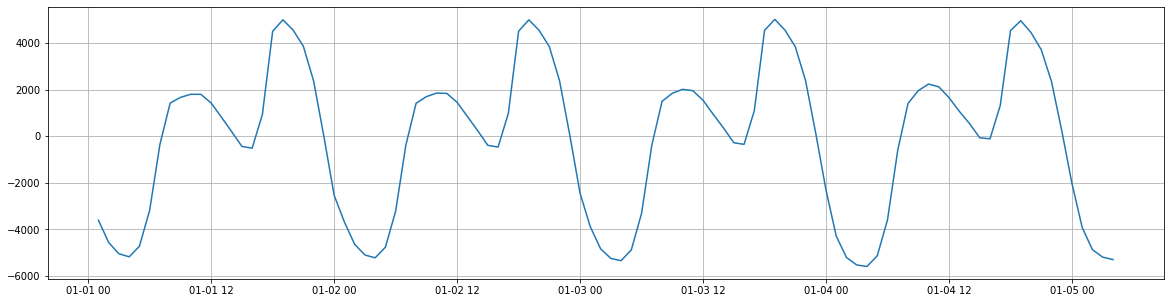

In [12]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(Trend[:500])
plt.show()
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(Season[:100])
plt.show()

Оценим остатки:

In [45]:

from statsmodels.tsa.stattools import adfuller
print('не стационарный с вероятностью : ',adfuller(res.resid[:200], regression='ctt')[1])

не стационарный с вероятностью :  3.887108807345522e-09


Построим простую модель для дневных циклов:

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
# Соберем примеров для модели с глубиной р
data_d = pd.DataFrame(data=Season, index=data.index)
p = 24
for i in range(p):
    data_d['d'+str(p-i)]=0
    data_d['d'+str(p-i)].values[p:] = data_d['season'].values[i:-(p)+i]

In [48]:
data_d.drop(data_d.index[:p],axis=0,inplace=True)
data_d.head()

,season,d24,d23,d22,d21,d20,d19,d18,d17,d16,d15,d14,d13,d12,d11,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
2002-01-03 01:00:00,-3889.701438,-3682,-4635,-5097,-5219,-4766,-3222,-381,1416,1698,1851,1837,1453,849,242,-391,-465,980,4504,4994,4545,3844,2372,37,-2452
2002-01-03 02:00:00,-4829.743750,-4635,-5097,-5219,-4766,-3222,-381,1416,1698,1851,1837,1453,849,242,-391,-465,980,4504,4994,4545,3844,2372,37,-2452,-3889
2002-01-03 03:00:00,-5245.460327,-5097,-5219,-4766,-3222,-381,1416,1698,1851,1837,1453,849,242,-391,-465,980,4504,4994,4545,3844,2372,37,-2452,-3889,-4829
2002-01-03 04:00:00,-5343.703302,-5219,-4766,-3222,-381,1416,1698,1851,1837,1453,849,242,-391,-465,980,4504,4994,4545,3844,2372,37,-2452,-3889,-4829,-5245
2002-01-03 05:00:00,-4879.598290,-4766,-3222,-381,1416,1698,1851,1837,1453,849,242,-391,-465,980,4504,4994,4545,3844,2372,37,-2452,-3889,-4829,-5245,-5343


In [49]:
data_d.shape

(145326, 25)

In [0]:
h=1  # горизонт прогноза
y = data_d.iloc[h:,:1].values
x = data_d.iloc[:-h,:].values
# разберем выборку на тесты и тренировочный набор
N_split = 1000

X_train = x[:-N_split,:]
y_train = y[:-N_split,:]

X_test = x[-N_split:,:]
y_test = y[-N_split:,:]
# строим модель
model_g = GradientBoostingRegressor(n_estimators=100)
model_g.fit(X_train,y_train)

y_pred = model_g.predict(X_test)

Оценим модель:

ошибка MAE = 6969.598813282744


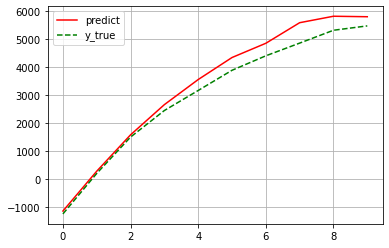

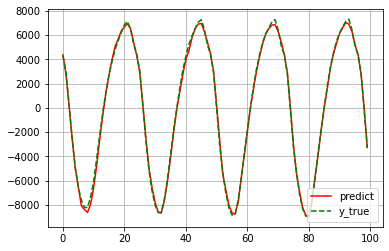

In [52]:
print('ошибка MAE =',np.mean(np.abs(y_pred-y_test)))

plt.plot(y_pred[:10],'r',label='predict')
plt.plot(y_test[:10],'--g',label='y_true')
plt.legend()
plt.grid()
plt.show()
plt.plot(y_pred[-100:],'r',label='predict')
plt.plot(y_test[-100:],'--g',label='y_true')
plt.legend()
plt.grid()
plt.show()

Результат работы можно еще раз обработать с другим лагом (недельные циклы)

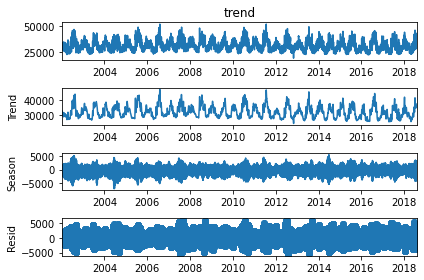

In [54]:
stlt = STL(Trend, period=7*24)
resw = stlt.fit()
fig = resw.plot()

Разница между моделями мультипликативного и аддитивного типа (https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose):

# - аддитивная у = тренд+сезон+остатки

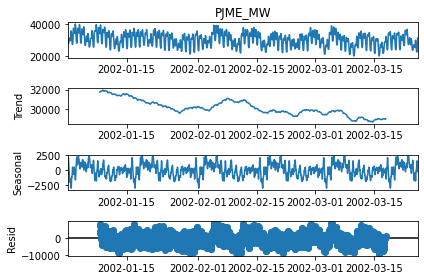

In [56]:
decomposition = sm.tsa.seasonal_decompose(data['PJME_MW'].iloc[:2000],  model='addinive', freq=365)
fig = decomposition.plot()
plt.show()

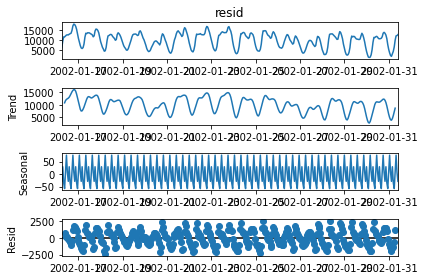

In [57]:
Trend=decomposition.trend
Season=decomposition.seasonal
resid = decomposition.resid

decomposition_w = sm.tsa.seasonal_decompose(resid[365:2*365]+10000,  model='additive', freq=7)
fig = decomposition_w.plot()
plt.show()



In [58]:
Week_s=decomposition_w.seasonal
Week_s[:14]

2002-01-16 06:00:00   -28.931093
2002-01-16 07:00:00    29.654488
2002-01-16 08:00:00   -34.980468
2002-01-16 09:00:00   -57.953194
2002-01-16 10:00:00     8.349534
2002-01-16 11:00:00    76.050294
2002-01-16 12:00:00     7.810439
2002-01-16 13:00:00   -28.931093
2002-01-16 14:00:00    29.654488
2002-01-16 15:00:00   -34.980468
2002-01-16 16:00:00   -57.953194
2002-01-16 17:00:00     8.349534
2002-01-16 18:00:00    76.050294
2002-01-16 19:00:00     7.810439
Name: seasonal, dtype: float64

 -  Мельтипликативная у = тренд * сезон * остатки

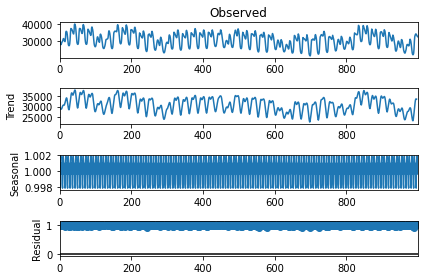

In [59]:
mean_s = sm.tsa.seasonal_decompose(data['PJME_MW'].values[:1000],  model='multiplicative', freq=7)
fig = mean_s.plot()
plt.show()


## Пророк предсказание: (https://habr.com/ru/company/ods/blog/323730/)

ДЕЛАЕТ АДДИТИВНУЮ РЕГРЕССИОННУЮ МОДЕЛЬ
 Y = T(t) + S(t) + h(t) + e(t)
 T - тренд
 S - сезон
 h -  особые дни

Порядок обработки:
 - создаем модель, 
 - вызываем метод fit
 - predict получаем прогноз. 
 
На вход методу fit библиотека принимает dataframe с двумя колонками:
ds — время, поле должно быть типа date или datetime,
y — числовой показатель, который мы хотим предсказывать.


In [0]:
from fbprophet import Prophet

Строим данные : обязательные поля ds , y

In [70]:
data_prop=data.iloc[:,:1].copy()
data_prop = data_prop.resample('D').apply(sum)
data_prop=data_prop.reset_index()
data_prop.columns=['ds','y']

data_prop.head()

,ds,y
0,2002-01-01,714857.0
1,2002-01-02,822277.0
2,2002-01-03,828285.0
3,2002-01-04,809171.0
4,2002-01-05,729723.0


Генерим модель:

In [72]:


m = Prophet( )
m.fit(data_prop.iloc[:1100,:])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Делаем предсказанием на 100 дней 

In [0]:
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

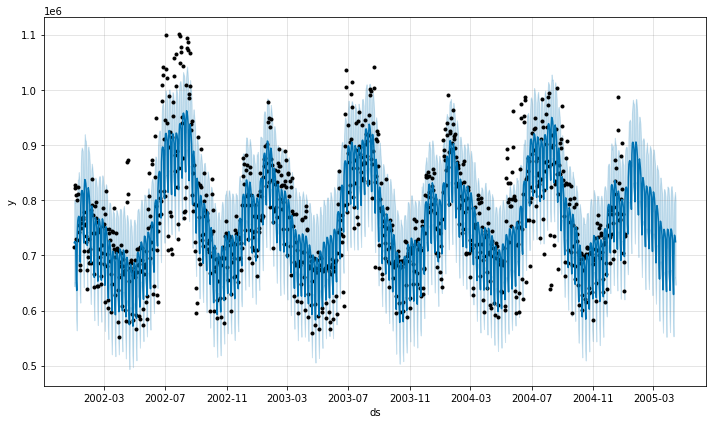

In [76]:
m.plot(forecast)
plt.show()